In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
pd.set_option("display.max_columns", None)
from scipy.stats import f_oneway
import xgboost as xgb
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score

os.chdir('/content/drive/MyDrive/Fairness_NLP/')

In [3]:
import re

def extract_text(input_string):
  # Check if the input is a string
    if not isinstance(input_string, str):
        print(input_string)
        raise ValueError("Expected a string input")
    # Use regex to find all text within parentheses and remove the text itself
    matches = re.findall(r'\((.*?)\)', input_string)

    if not matches:
        return input_string

    # Join the extracted texts with a space and return them
    return ' '.join(matches)

# Below helper function creates question-answer pairs (without filtering)
def create_question_answer_pairs(interview):
    question_answer_pairs = []
    current_question = []
    current_response = []

    for index, row in interview.iterrows():
        row['value'] = extract_text(str(row['value']))
        if row['speaker'] == "Ellie":
            # If there's an existing question and response, store the pair
            if current_question and current_response:

                question_answer_pairs.append({
                    'question': " ".join(current_question),
                    'answer': ". ".join(current_response)
                })
                current_response = []  # Reset responses for the next question
                current_question = []  # Reset question for the next batch

            # Add the new question or follow-up from Ellie to the current question
            current_question.append(str(row['value']))

        elif row['speaker'] == "Participant" and current_question:
            current_response.append(str(row['value']))

    # Add the last question-answer pair if it exists
    if current_question and current_response:

        question_answer_pairs.append({
            'question': " ".join(current_question),
            'answer': ". ".join(current_response)
        })

    return pd.DataFrame(question_answer_pairs, columns=['question', 'answer'])

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Create dictionary of {participant_id : PHQ_Binary}
id_depression_label_map = {}
all_ids = set()
sheet_name = 'Metadata_mapping'
file_path = 'DAIC demographc data.xlsx'
data_csv = pd.read_excel(file_path, sheet_name=sheet_name)
for i in range(len(data_csv['Participant_ID'])):
    id_depression_label_map[data_csv['Participant_ID'][i]] = data_csv['PHQ_Binary'][i]
    all_ids.add(data_csv['Participant_ID'][i])


In [5]:
from transformers import AutoTokenizer
access_token = "TOKEN"

tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base", token=access_token)
import torch

max_len = 510
ids_collected = []
all_qas_df = []
def collect_train_test_data(directory):
    X_train = []
    Y_train = []
    attention_masks = []
    for filename in os.listdir(directory):
      if filename.endswith(".csv"):
        interview_id = re.findall(r'\d+', filename)[0]
        ids_collected.append(interview_id)

        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, delimiter='\t')
        df.drop(columns=['start_time', 'stop_time'], axis=1, inplace=True)
        df.fillna('', inplace=True)

        # Step 1: Create QA Pair
        qa_df = create_question_answer_pairs(df)
        all_qas_df.append(qa_df)
        Y_train.append(id_depression_label_map[int(interview_id)])

    return all_qas_df, Y_train

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [6]:

# Load the data
directory = '/content/drive/MyDrive/Fairness_NLP/Dataset'
all_qas_df, Y_train = collect_train_test_data(directory)


In [9]:
print(len(all_qas_df))

186


In [11]:
import pickle
with open('/content/drive/MyDrive/Fairness_NLP/RULE_BASED/pronoun_embeddings.pkl', 'rb') as file:
    true_dict = pickle.load(file)

In [12]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load transformer model and tokenizer
access_token = "TOKEN"


model_name = "mental/mental-roberta-base"  # or any transformer model of choice
tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
model = AutoModel.from_pretrained(model_name, token=access_token).to(device)

# Load spaCy model for English
nlp = spacy.load("en_core_web_sm")

# Function to find pronouns in a sentence using spaCy
def extract_pronouns_spacy(sentence):
    doc = nlp(sentence)
    pronouns = [token.text for token in doc if token.pos_ == "PRON"]
    return pronouns

# Function to get a window of context around the current QA pair
def build_context_window(df, current_index, window_before=1, window_after=1):
    context = []
    # Add previous QA pairs within the window
    start_index = max(0, current_index - window_before)
    # Add next QA pairs within the window
    end_index = min(len(df), current_index + window_after + 1)

    for i in range(start_index, end_index):
        context.append(df.iloc[i]['question'] + " " + df.iloc[i]['answer'])

    return " ".join(context)

# Function to get embeddings for pronouns in context
def get_pronouns_embeddings(df_list, Y_train, parameters, window_before=1, window_after=1):
  Acc = []
  Bacc = []
  Prec = []
  Rec = []
  F1 = []
  for parameter in range(len(parameters)):
      embeddings = []
      y_prediction = []
      c = 0
      for df in df_list:
          pronoun_count = 0
          pronoun_depressed = 0
          for i, row in df.iterrows():
              interviewer_text = row['question']
              interviewee_text = row['answer']

              # Extract pronouns from interviewee's response
              pronouns = extract_pronouns_spacy(interviewee_text)
              if not pronouns:
                  continue

              # Build context window around the current QA pair
              context = build_context_window(df, i, window_before=window_before, window_after=window_after)

              # Truncate or pad context to fit within 512 tokens
              inputs = tokenizer(context, return_tensors='pt', max_length=512, truncation=True, padding='max_length').to(device)

              # Get embeddings from the model
              with torch.no_grad():
                  outputs = model(**inputs)

              # Get embeddings for pronouns
              for pronoun in pronouns:

                  # Find the index of each pronouns in the tokenized context
                  pronoun_tokens = tokenizer.tokenize(pronoun)
                  pronoun_token_id = tokenizer.convert_tokens_to_ids(pronoun_tokens[0])  # ID of the first token of the pronoun
                  pronoun_index = (inputs.input_ids[0] == pronoun_token_id).nonzero(as_tuple=True)[0]  # Find position of token in input

                  if len(pronoun_index) > 0:  # Ensure pronoun token was found
                      pronoun_embedding = outputs.last_hidden_state[0, pronoun_index[0], :].cpu().numpy()
                      #embeddings.append((pronoun, pronoun_embedding))
                      if pronoun in true_dict:
                          pronoun_count+=1
                          true_embedding = true_dict[pronoun]
                          similarity = cosine_similarity([pronoun_embedding], [true_embedding])[0][0]
                          #print(f"Cosine similarity for '{pronoun}': {similarity}")
                          if similarity>parameters[parameter][0]:
                            pronoun_depressed+=1

          try:
            if (pronoun_depressed/pronoun_count) > parameters[parameter][0]:
              y_prediction.append(1)
            else:
              y_prediction.append(0)
          except Exception as exp:
              y_prediction.append(0)
          c+=1
      predicted_labels = y_prediction
      true_labels = Y_train
      # Calculating metrics
      precision = precision_score(true_labels, predicted_labels, average='binary')
      recall = recall_score(true_labels, predicted_labels, average='binary')
      f1 = f1_score(true_labels, predicted_labels, average='binary')
      balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
      accuracy = accuracy_score(true_labels, predicted_labels)

      # Printing results
      #print(f"Precision: {precision}")
      #print(f"Recall: {recall}")
      #print(f"F1 Score: {f1}")
      #print(f"Balanced Accuracy: {balanced_accuracy}")
      #print(f"Accuracy: {accuracy}")

      Acc.append(accuracy)
      Bacc.append(balanced_accuracy)
      Prec.append(precision)
      Rec.append(recall)
      F1.append(f1)
      print(parameter)
  return Acc, Bacc, Prec, Rec, F1

# Example usage
# df_list is a list of dataframes, each with 'Interviewer' and 'Interviewee' columns
# Example: df_list = [df1, df2, ...]
parameters = [(0.75,0.15),(0.75,0.05),(0.75,0.95),(0.85,0.9),(0.85,0.95),(0.85,0.98)]
Acc, Bacc, Prec, Rec, F1 = get_pronouns_embeddings(all_qas_df, Y_train, parameters, window_before=15, window_after=15)


Using device: cuda


config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
1
2
3
4
5


In [13]:
print(Acc, Bacc, Prec, Rec, F1)

[0.3279569892473118, 0.3279569892473118, 0.3279569892473118, 0.44086021505376344, 0.44086021505376344, 0.44086021505376344] [0.47321428571428575, 0.47321428571428575, 0.47321428571428575, 0.529265873015873, 0.529265873015873, 0.529265873015873] [0.21379310344827587, 0.21379310344827587, 0.21379310344827587, 0.24166666666666667, 0.24166666666666667, 0.24166666666666667] [0.7380952380952381, 0.7380952380952381, 0.7380952380952381, 0.6904761904761905, 0.6904761904761905, 0.6904761904761905] [0.3315508021390374, 0.3315508021390374, 0.3315508021390374, 0.35802469135802467, 0.35802469135802467, 0.35802469135802467]


#Plot the graph

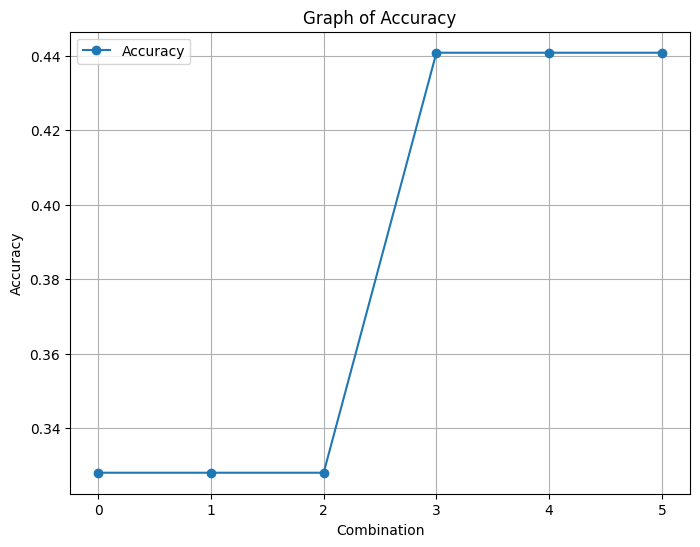

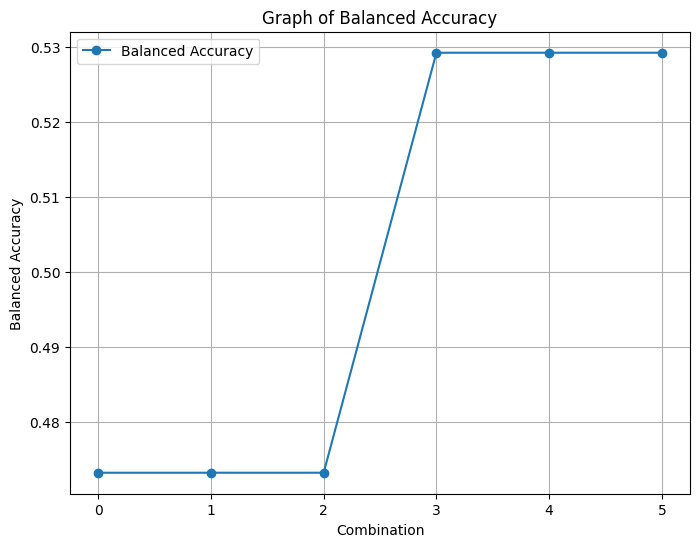

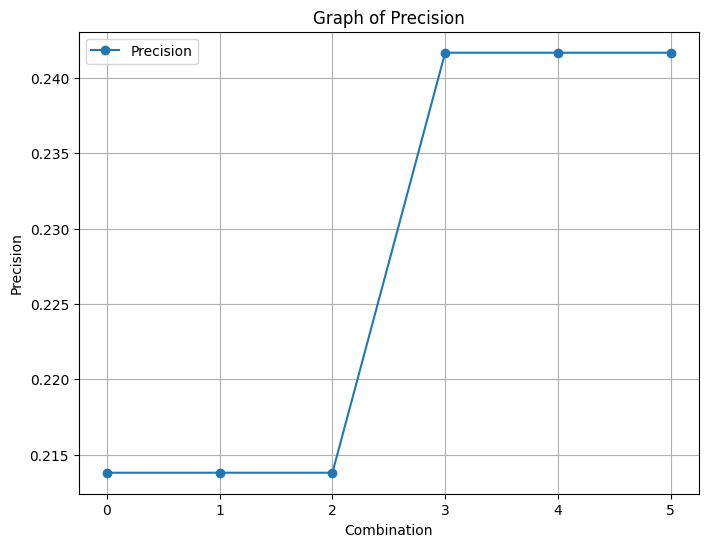

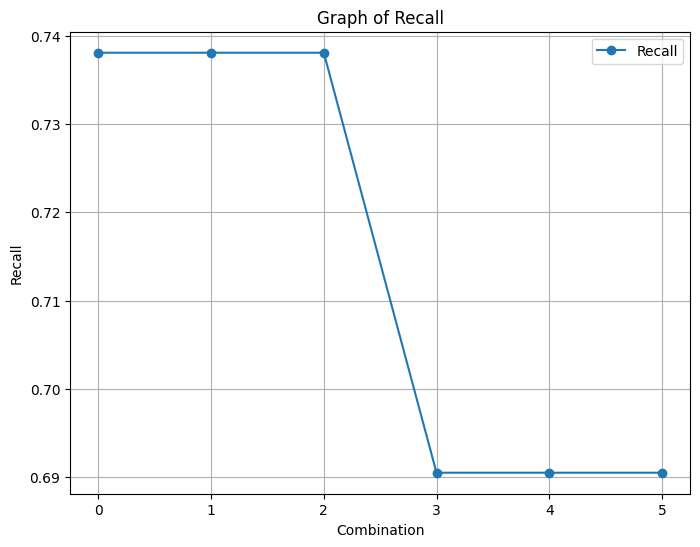

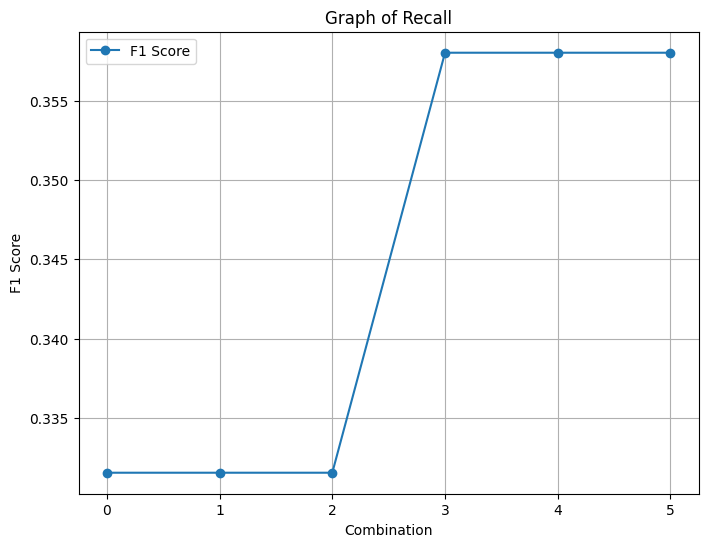

In [14]:
# [(0.75,0.25),(0.75,0.5),(0.75,0.75),(0.8,0.25),(0.8,0.5),(0.8,0.75),(0.85,0.25),(0.85,0.5),(0.85,0.75)]
import matplotlib.pyplot as plt

# Sample data (replace these with your actual lists)
list1 = range(9)

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Acc, label='Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Accuracy")
plt.xlabel("Combination")
plt.ylabel("Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


# Plotting the line graph
plt.figure(figsize=(8, 6))
# Line for list1
plt.plot(Bacc, label='Balanced Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Balanced Accuracy")
plt.xlabel("Combination")
plt.ylabel("Balanced Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
  # Line for list1
plt.plot(Prec, label='Precision', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Precision")
plt.xlabel("Combination")
plt.ylabel("Precision")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Rec, label='Recall', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("Recall")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(F1, label='F1 Score', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("F1 Score")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


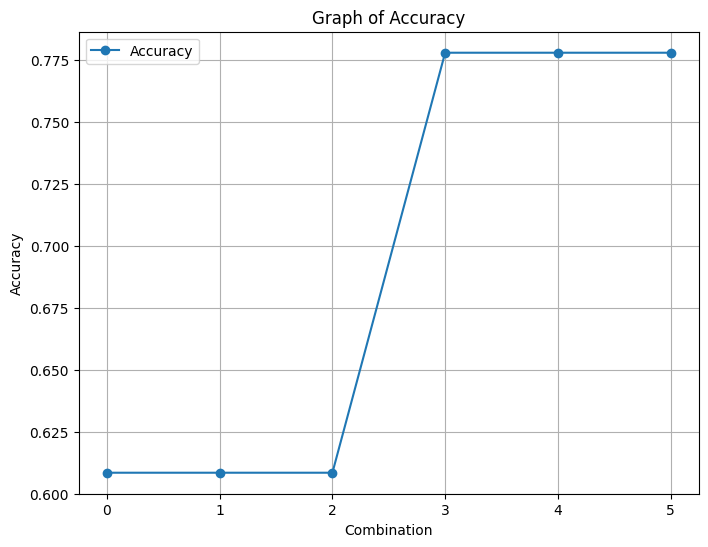

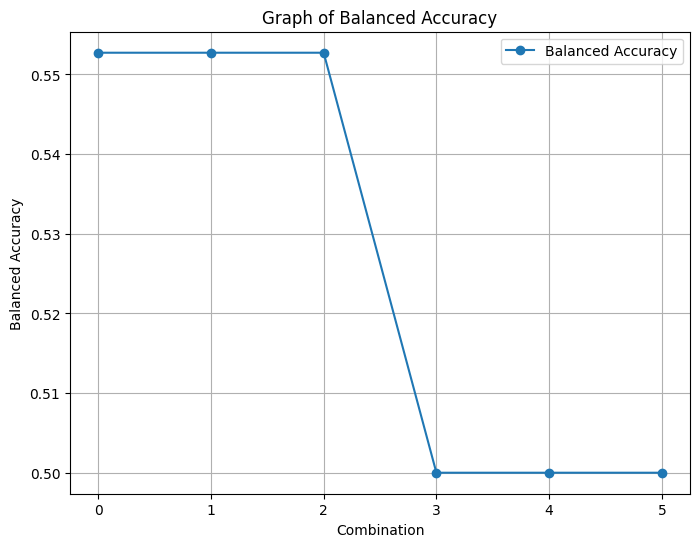

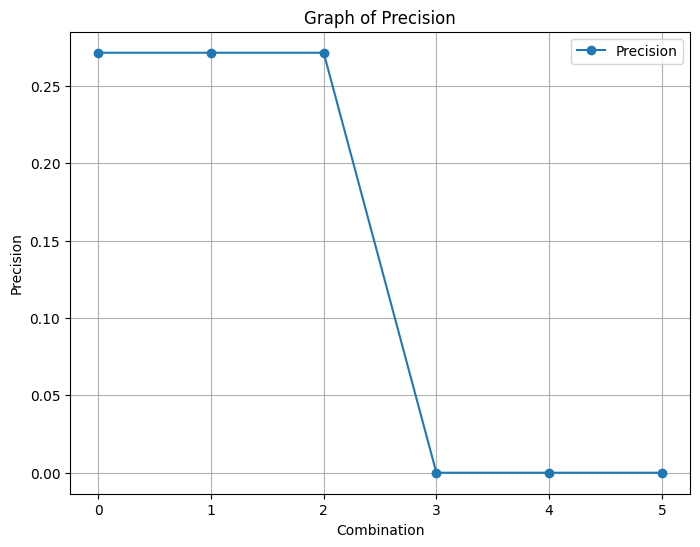

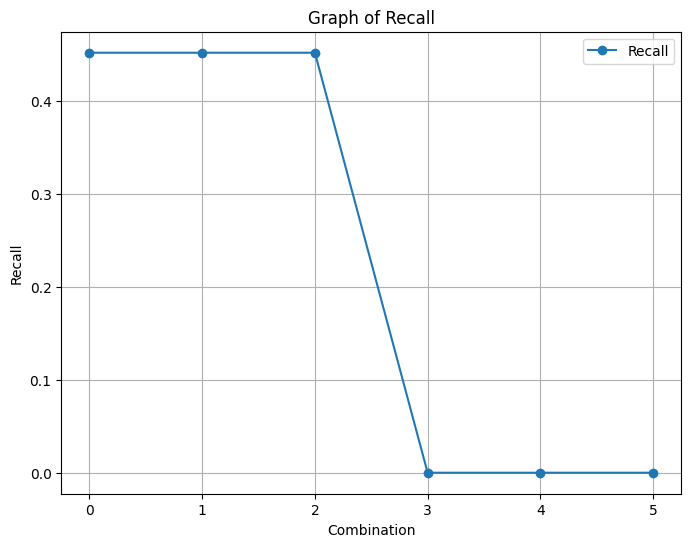

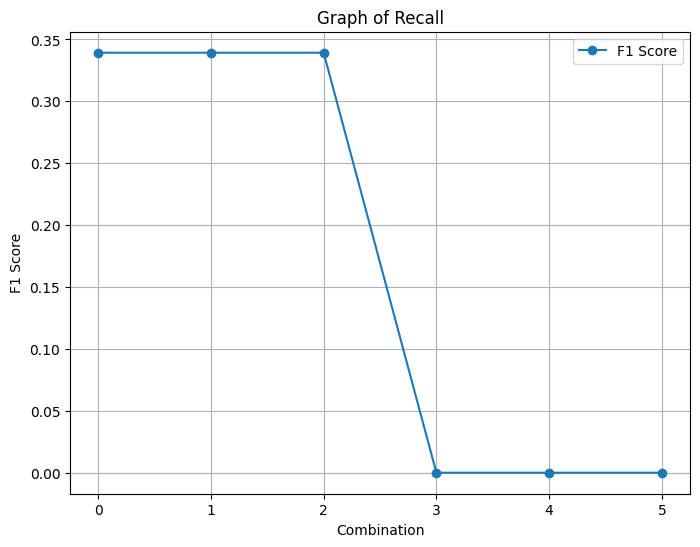

In [ ]:
# [(0.75,0.25),(0.75,0.5),(0.75,0.75),(0.8,0.25),(0.8,0.5),(0.8,0.75),(0.85,0.25),(0.85,0.5),(0.85,0.75)]
import matplotlib.pyplot as plt

# Sample data (replace these with your actual lists)
list1 = range(9)

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Acc, label='Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Accuracy")
plt.xlabel("Combination")
plt.ylabel("Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


# Plotting the line graph
plt.figure(figsize=(8, 6))
# Line for list1
plt.plot(Bacc, label='Balanced Accuracy', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Balanced Accuracy")
plt.xlabel("Combination")
plt.ylabel("Balanced Accuracy")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
  # Line for list1
plt.plot(Prec, label='Precision', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Precision")
plt.xlabel("Combination")
plt.ylabel("Precision")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(Rec, label='Recall', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("Recall")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()

# Plotting the line graph
plt.figure(figsize=(8, 6))
 # Line for list1
plt.plot(F1, label='F1 Score', marker='o')  # Line for list2

# Adding titles and labels
plt.title("Graph of Recall")
plt.xlabel("Combination")
plt.ylabel("F1 Score")
plt.legend()  # Show the legend to differentiate between the two lists
plt.grid(True)  # Optional: Add a grid for better readability

# Display the plot
plt.show()


In [ ]:
from huggingface_hub import login
from google.colab import userdata

my_secret_key = userdata.get('HF_TOKEN')
# Log in programmatically
login(token=my_secret_key)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# Generate QA sentences

In [ ]:
# Sample list of dataframes named dfs, each with columns 'Question' and 'Answer'
# Replace `dfs` with the name of your actual list of dataframes

def concatenate_conversations(dfs):
    all_conversations = []

    for df in dfs:
        conversation = ""

        for _, row in df.iterrows():
            # Adding prefix for interviewer question
            conversation += f"[Interviewer]: {row['question']} "

            # Adding prefix for patient answer
            conversation += f"[Patient]: {row['answer']} "

        # Strip any trailing whitespace and add to the list of conversations
        all_conversations.append(conversation.strip())

    return all_conversations

# Example usage
concatenated_conversations = concatenate_conversations(all_qas_df)

with open("conversations.pkl", "rb") as file:
    loaded_conversations = pickle.load(file)


FileNotFoundError: [Errno 2] No such file or directory: 'conversations.pkl'

In [ ]:
file_path = './conversations.txt'
with open(file_path, "w") as file:
    for conversation in concatenated_conversations:
        file.write(conversation + "\n")

In [ ]:
file_path = './conversations_labels.txt'
with open(file_path, "w") as file:
    for conversation in Y_train:
        file.write(str(conversation) + "\n")

In [ ]:
with open("conversations_llama_predictions.txt", "r") as file:
    prediction = [line[0] for line in file]

In [ ]:
type(Y_train[0])
ytrain_string = [str(i) for i in Y_train]

In [ ]:
set(prediction)

{'0', '1'}

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, balanced_accuracy_score
label = ytrain_string
output_labels = prediction
precision = precision_score(label, output_labels, pos_label='1')
recall = recall_score(label, output_labels, pos_label='1')
f1 = f1_score(label, output_labels, pos_label='1')
acc = accuracy_score(label, output_labels)
bcc = balanced_accuracy_score(label, output_labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy Score: {acc}")
print(f"Balanced Accuracy Score: {bcc}")

Precision: 0.25217391304347825
Recall: 0.6904761904761905
F1 Score: 0.36942675159235666
Accuracy Score: 0.47619047619047616
Balanced Accuracy Score: 0.5527210884353742


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score
predicted_labels = adjective_embeddings
true_labels = Y_train
# Calculating metrics
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
f1 = f1_score(true_labels, predicted_labels, average='binary')
balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)

# Printing results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"Accuracy: {accuracy}")

Precision: 0.2154696132596685
Recall: 0.9285714285714286
F1 Score: 0.34977578475336324
Balanced Accuracy: 0.48129251700680276
Accuracy: 0.2328042328042328
